## Elia Fantini & Félix Klein
### SCIPER : 336006 & 344259

# 3. Deep Q-Learning

In [1]:
import numpy as np
from nim_env import NimEnv, OptimalPlayer
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
import copy
from itertools import count
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import random
from nim_env import NimEnv, OptimalPlayer
import numpy as np
from tqdm import  tqdm
import cProfile
import pstats
from collections import namedtuple, deque

In [3]:
MAX_STICKS=7
NUM_HEAPS=3
METRICS_FREQUENCY=250

In [4]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class Buffer(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def get_memory(self):
        return self.memory

    def set_memory(self, memory):
        self.memory = memory

    def __len__(self):
        return len(self.memory)

In [5]:
class Qnetwork(nn.Module):
    def __init__(self):
        super(Qnetwork, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(9, 128),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU())
        self.linear = nn.Linear(128, 21)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        return self.linear(x)

In [49]:
class DQNAgent:
    def __init__(self, epsilon = 0.1, epsilon_min = None, epsilon_max = None, n_star = 1, gamma = 0.99, batch_size = 64, buffer_size= 10000, learning_rate = 5e-4, c = 500, criterion = nn.HuberLoss(delta=1.0), self_learning = False):
        # if a GPU is available
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.self_learning = self_learning
        self.player = None
        self.buffer = Buffer(capacity=buffer_size)

        self.state = None
        self.action = None
        self.state_adv = None
        self.action_adv = None



        #self.q_value_theta = None
        self.gamma = gamma                        # discount factor

        # for epsilon-greedy policy and decreasing exploration
        self.epsilon = epsilon
        if epsilon_min == None:
            self.epsilon_min = epsilon
        else:
            self.epsilon_min = epsilon_min
        if epsilon_max == None:
            self.epsilon_max = epsilon
        else:
            self.epsilon_max = epsilon_max
        self.c = c
        self.n = 0  # game counter
        self.n_star = n_star

        self.batch_size = min(batch_size, buffer_size)
        self.learning_rate = learning_rate
        # as required, the criterion is the Huber loss with delta = 1
        self.criterion = criterion.to(self.device)

        self.model = Qnetwork().to(self.device)
        self.target = Qnetwork().to(self.device)
        self.target.load_state_dict(self.model.state_dict())

        # as required, we use the Adam optimizer
        self.optimizer = optim.Adam(self.model.parameters(), lr = learning_rate)
        """self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer,factor=0.9,mode = "max", patience=1, verbose=True)"""


    def heaps_to_binary(self, heaps):
        """
        Converts heaps state into three binary numbers to feed them into the Q-Network for DQN
        Args:
            heaps: list of integers
                list of heap sizes.

        Returns:
            bin_seq: torch.tensor
                3-bit binary representation of all 3 heaps, concatenated
        """
        bin_seq = []
        for i in range(NUM_HEAPS):
            # convert the number of sticks in each heap in a 3-bit binary representation
            binary_string = format(heaps[i], "b").zfill(3)
            for i in binary_string:
                bin_seq.append(int(i))
        return torch.tensor(bin_seq, dtype=torch.float, device=self.device)

    def decrease_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon_max * (1 - self.n / self.n_star))


    def randomMove(self, heaps):
        """
        same function as the one from OptimalPlayer
        """
        # the indexes of the heaps available are given by
        heaps_avail = [i for i in range(len(heaps)) if heaps[i] > 0]
        chosen_heap = random.choice(heaps_avail)
        n_obj = random.choice(range(1, heaps[chosen_heap] + 1))
        move = [chosen_heap + 1, n_obj]
        return move

    def act_dqn(self, heaps, test = False, is_adversary = False):
        """
        action function, epsilon-greedy
        """
        state = self.heaps_to_binary(heaps)
        if is_adversary:
            self.state_adv = state
        else:
            self.state = state
        if np.random.rand() < self.epsilon and not test:
            move = self.randomMove(heaps)
            action = (move[0] - 1) * MAX_STICKS + move[1] - 1
            """action = int(torch.randint(size=[1],low=0, high=MAX_STICKS*NUM_HEAPS).item())
            move = [(action // MAX_STICKS) + 1, (action % MAX_STICKS) + 1]"""
        else:
            with torch.no_grad():
                action = int(torch.argmax(self.model(state)).item())
            move = [(action // MAX_STICKS) + 1, (action % MAX_STICKS) + 1]

        # transform index of best action to a representation that the environment understands (from heap a, take b sticks)
        if is_adversary:
            self.action_adv = action
        else:
            self.action = action

        return move

    def learn(self, state, reward, end = False, is_adversary = False):
        if not end:
            next_state = self.heaps_to_binary(state)
            if is_adversary:
                self.buffer.push(self.state_adv, torch.tensor(self.action_adv,dtype=torch.int64, device= self.device), next_state, torch.tensor(reward,dtype=torch.float, requires_grad=True, device= self.device))
            else:
                self.buffer.push(self.state, torch.tensor(self.action,dtype=torch.int64, device= self.device), next_state, torch.tensor(reward,dtype=torch.float, requires_grad=True, device= self.device))
        else:
            if is_adversary:
                self.buffer.push(self.state_adv, torch.tensor(self.action_adv,dtype=torch.int64, device= self.device), None, torch.tensor(reward,dtype=torch.float, requires_grad=True, device= self.device))
            else:
                self.buffer.push(self.state, torch.tensor(self.action,dtype=torch.int64, device= self.device), None, torch.tensor(reward,dtype=torch.float, requires_grad=True, device= self.device))

        # we then have to manage the first few rounds, when the replay buffer is smaller than the batch size (default case 64)
        if len(self.buffer) < self.batch_size :
            return

        transitions = self.buffer.sample(self.batch_size)
        batch = Transition(*zip(*transitions))
        state_batch = torch.stack(batch.state)
        action_batch = torch.stack(batch.action)
        reward_batch = torch.stack(batch.reward)


        q_values_theta = self.model(state_batch).gather(1, action_batch.reshape((self.batch_size,1)))

        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                    batch.next_state)), device=self.device, dtype=torch.bool)
        non_final_next_states = [s for s in batch.next_state
                                           if s is not None]
        if non_final_next_states: # if the list is not empty
            non_final_next_states = torch.stack(non_final_next_states)
            next_state_values = torch.zeros(self.batch_size, device=self.device)
            with torch.no_grad():
                next_state_values[non_final_mask] = self.target(non_final_next_states).max(1)[0].detach()

            expected_state_action_values = (next_state_values * self.gamma) + reward_batch
        else:
            expected_state_action_values = reward_batch

        loss = self.criterion(q_values_theta, expected_state_action_values.unsqueeze(1))
        loss_item = loss.item()
        self.optimizer.zero_grad()
        loss.backward()
        """for param in self.model.parameters():
            param.grad.data.clamp_(-1, 1)"""
        self.optimizer.step()
        # update

        return loss_item
        # increment round counter

    def reset_game(self, test = False):
        self.action = None
        self.state = None
        self.state_adv = None
        self.action_adv = None
        if not test:
            # increase game counter
            self.n += 1
            # decrease exploration
            self.decrease_epsilon()

    def update_target(self):
        self.target.load_state_dict(self.model.state_dict())



    def load(self, name):
        return torch.load(name)

    def save(self, name):
        torch.save(self.model.state_dict(), name)

In [27]:
def deep_q_learning(maxGames=20000, env=NimEnv(), adv_epsilon = 0.5, c=500, player_dqn = None, test = False, self_learning = False):
    rewards = []
    rewards_mean = []
    losses = []
    losses_mean = []
    if test:
        m_opt=[]
        m_rand=[]


    if player_dqn is None:
        player_dqn = DQNAgent(self_learning = self_learning)

    Turn = 0
    for nbGames in tqdm(range(maxGames)):
        if not self_learning:
            player_adv=OptimalPlayer(player = Turn, epsilon=adv_epsilon)
        player_dqn.player = 1-Turn
        env.reset()
        heaps, _, __ = env.observe()
        lost_for_unavailable_move = False
        roundGame = 0
        while not env.end:
            if not env.current_player == player_dqn.player:
                # if it's the turn of the adversary
                if self_learning:
                    # player_adv.state = heaps
                    if roundGame>1:
                        loss=player_dqn.learn(heaps, 0, is_adversary= True)
                        if loss is not None :
                                losses.append(loss)
                    move = player_dqn.act_dqn(heaps, is_adversary= True)
                else:
                    move = player_adv.act(heaps)
            else:
                # if it's the agent's turn
                if isinstance(player_dqn, DQNAgent):
                    if roundGame>1: # if it's round 0 or 1, it's still first move for dqnAgent, there's no state and action to be memorized yet (they are the default, None)
                        loss=player_dqn.learn(heaps, 0)
                        if loss is not None :
                            losses.append(loss)
                    move = player_dqn.act_dqn(heaps)

            try:
                heaps, end, winner = env.step(move)
            except AssertionError:
                # if move is unavailable, the player that made the move loses and the game ends
                env.end = True
                end = True
                env.num_step += 1
                winner = 1 - env.current_player
                lost_for_unavailable_move = True

            if end:
                if winner == player_dqn.player:
                    rewards.append(1)
                    if self_learning:
                        loss=player_dqn.learn(heaps, -1, end = True, is_adversary= True)
                        if loss is not None :
                                losses.append(loss)
                    if isinstance(player_dqn, DQNAgent) and not lost_for_unavailable_move:
                        loss=player_dqn.learn(heaps, 1, end = True)
                        if loss is not None :
                                losses.append(loss)
                else:
                    rewards.append(-1)
                    if self_learning and not lost_for_unavailable_move:
                        loss=player_dqn.learn(heaps, 1, end = True, is_adversary= True)
                        if loss is not None :
                                losses.append(loss)
                    if isinstance(player_dqn, DQNAgent):
                        loss=player_dqn.learn(heaps, -1, end = True)
                        if loss is not None :
                                losses.append(loss)
                player_dqn.reset_game()
            roundGame += 1


        Turn = 1 - Turn
        # every 250 games, compute average reward for plotting
        if nbGames%METRICS_FREQUENCY == METRICS_FREQUENCY -1 and nbGames!=0:
            rewards_mean.append(np.array(rewards).mean())
            #print(np.array(rewards).mean())
            losses_mean.append(np.array(losses).mean())
            losses = []
            rewards = []
            if test:
                for eps_opt in [0,1]:
                    won_count=0
                    for i in range(500):
                        player_adv=OptimalPlayer(player = Turn, epsilon=eps_opt)
                        player_dqn.player = 1-Turn
                        env.reset()
                        heaps, _, __ = env.observe()

                        while not env.end:
                            if env.current_player == player_adv.player:
                                # if it's the turn of the adversary
                                    move = player_adv.act(heaps)
                            else:
                                # if it's the agent's turn
                                if isinstance(player_dqn, DQNAgent):
                                    move = player_dqn.act_dqn(heaps, test=True)

                            try:
                                heaps, end, winner = env.step(move)
                            except AssertionError:
                                # if move is unavailable, the player that made the move loses and the game ends
                                env.end = True
                                end = True
                                env.num_step += 1
                                winner = 1 - env.current_player     # The opposite of the one who did the last, incorrect move.
                            if end:
                                if winner == player_dqn.player:
                                    won_count += 1
                                player_dqn.reset_game(test=True)
                        Turn = 1 - Turn
                    m=(won_count-(500-won_count))/500
                    if eps_opt==0:
                        m_opt.append(m)
                    else:
                        m_rand.append(m)

        if (nbGames + 1)%c ==0:
            player_dqn.update_target()
    env.reset()
    metrics = []
    metrics.append(rewards_mean)
    metrics.append(losses_mean)
    if test:
        metrics.append(m_opt)
        metrics.append(m_rand)
    return metrics, player_dqn

In [22]:
def single_image_subplots(title, list_of_data, plots_values= None, plot_cols=1, tot_height=0, tot_width=0):
    """
    Displays one or multiple plots given the data contained in list of data. Plots may contain one or more lines.
    Args:
        title: str
            title of the plot
        list_of_data: list of lists
            list containing the "metrics" output of one or more q_learning function's executions.
        plots_values: list of float
            parameter's value to be put as subtitle over the plot that was generated by such value. Default is None
        plot_cols: int
            num of columns of the plots grid. Default is 1
        tot_height: int
            height of the whole image. Default is 0 for single plot images
        tot_width: int
            height of the whole image. Default is 0 for single plot images

    """

    num_plots=len(list_of_data)

    fig, axs = plt.subplots(int(num_plots/plot_cols), plot_cols, sharey=True)
    fig.suptitle(title, fontsize=16)
    if type(axs)!=np.ndarray :
        axs= np.asarray(axs)
    num_games=np.arange(1,len(list_of_data[0][0])+1)*METRICS_FREQUENCY
    for i, ax in enumerate(axs.flat):
        data = list_of_data[i]
        label=["Mean reward","Loss","M-opt","M-rand"]
        for ii in range(len(list_of_data[i])):
            ax.plot(num_games,data[ii], label=label[ii])

        if plots_values is not None:
            ax.set_title("Value: " + str(round(plots_values[i],2)))
        ax.legend()
    fig.text(0.5, 0.04, 'Games', ha='center')
    fig.text(0.04, 0.5, 'Metrics', va='center', rotation='vertical')
    if tot_height!=0:
        fig = plt.gcf()
        fig.set_size_inches(tot_width, tot_height)

    plt.show()

In [ ]:
use_backup = True

In [12]:
import pickle
if use_backup:
    file_name = "deep_q_learning_results.pkl"
    open_file = open(file_name, "rb")
    training_results = pickle.load(open_file)
    open_file.close()
else:
    deep_q_questions_results = []

## 3.2 Learning from experts
Implement the DQN algorithm. To check the algorithm, run a DQN agent with a fixed and arbitrary eps ∈ [0, 1) against Opt(0.5) for 20’000 games – switch the 1st player after every game.
### Question 11
Plot average reward and average training loss for every 250 games during training. Doesthe loss decrease? Does the agent learn to play Nim? Expected answer: A figure with two subplots (caption length < 250 words). Specify your choice of eps

In [13]:
if not use_backup:
    metrics, _ = deep_q_learning(player_dqn=DQNAgent(epsilon=0.1), adv_epsilon=0.5, maxGames=20000, test=False)
    deep_q_questions_results.append(metrics)

100%|██████████| 20000/20000 [05:19<00:00, 62.67it/s]


In [ ]:
metrics = deep_q_questions_results[0]

### Question 12
Repeat the training but without the replay buffer and with a batch size of 1: At every step, update the network by using only the latest transition. What do you observe?
Expected answer: A figure with two subplots showing average reward and average training loss during training (caption length < 50 words)

In [15]:
if not use_backup:
    metrics, _  =  deep_q_learning(player_dqn=DQNAgent(epsilon=0.1, buffer_size=1), adv_epsilon=0.5, maxGames=20000, test=False)
    deep_q_questions_results.append(metrics)

100%|██████████| 20000/20000 [04:10<00:00, 79.84it/s]


Instead of fixing eps, use eps(n) in Equation 1. For different values of n, run your DQN against Opt(0.5) for 20’000 games – switch the 1st player after every game. Choose several values of n from a reasonably wide interval between 1 to 40’000 – particularly, include n* = 1.
### Question 13
After every 250 games during training, compute the ‘test’ Mopt and Mrand for your agents. Plot Mopt and Mrand over time. Does decreasing eps help training compared to having a fixed eps? What is the effect of n* ?
Expected answer: A figure showing Mopt and Mrand over time for different values of speeds of n* (caption length < 250 words).

In [19]:
if not use_backup:
    question13_results=[]
    n_star_values=np.linspace(1,40000,6)
    for n_star in n_star_values:
        metrics, _  =  deep_q_learning(player_dqn=DQNAgent(epsilon_min=0.1, epsilon_max=0.8, n_star= n_star), adv_epsilon=0.5, maxGames=20000, test=True)
        question13_results.append(metrics)
    deep_q_questions_results.append(question13_results)

100%|██████████| 20000/20000 [06:44<00:00, 49.48it/s]


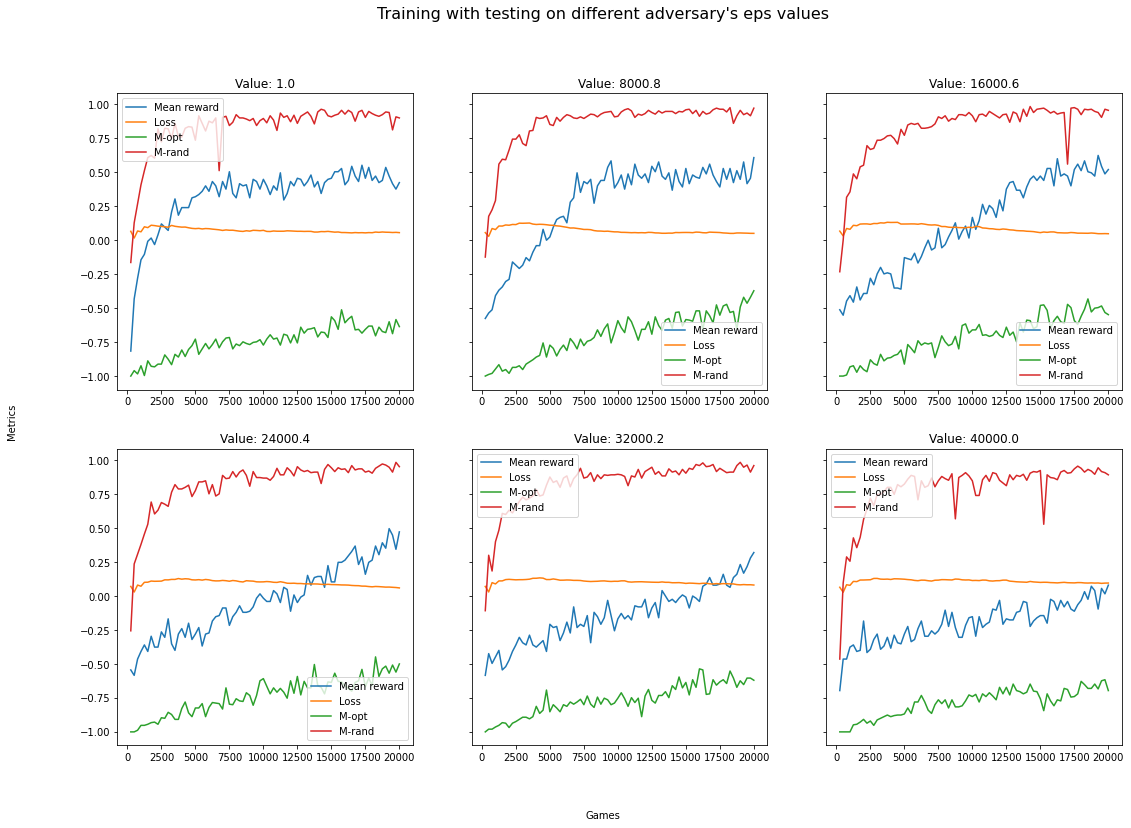

In [25]:
n_star_values=np.linspace(1,40000,6)
question13_results = deep_q_questions_results[2]
single_image_subplots("Training with testing on different adversary's eps values", question13_results, n_star_values, 3, tot_height=12, tot_width=18)

Choose the best value of n* that you found. Run DQN against Opt(eps_opt) for different values of eps_opt for 20’000 games – switch the 1st player after every game.
Choose several values of eps_opt from a reasonably wide interval between 0 to 1 – particularly, include eps_opt = 0.
### Question 14
 After every 250 games during training, compute the ‘test’ Mopt and Mrand for your agents – for each value of eps_opt. Plot Mopt and Mrand over time. What do you observe? How can you explain it?
 Expected answer: A figure showing Mopt and Mrand over time for different values of eps_opt (caption length < 250 words).


In [28]:
if not use_backup:
    question14_results=[]
    eps_adv_values = np.linspace(0,1,11)
    for eps_adv in eps_adv_values:
        metrics, _  =  deep_q_learning(player_dqn=DQNAgent(epsilon_min=0.1, epsilon_max=0.8, n_star= 8000), adv_epsilon=eps_adv, maxGames=20000, test=True)
        question14_results.append(metrics)
    deep_q_questions_results.append(question14_results)

100%|██████████| 20000/20000 [06:53<00:00, 48.38it/s]


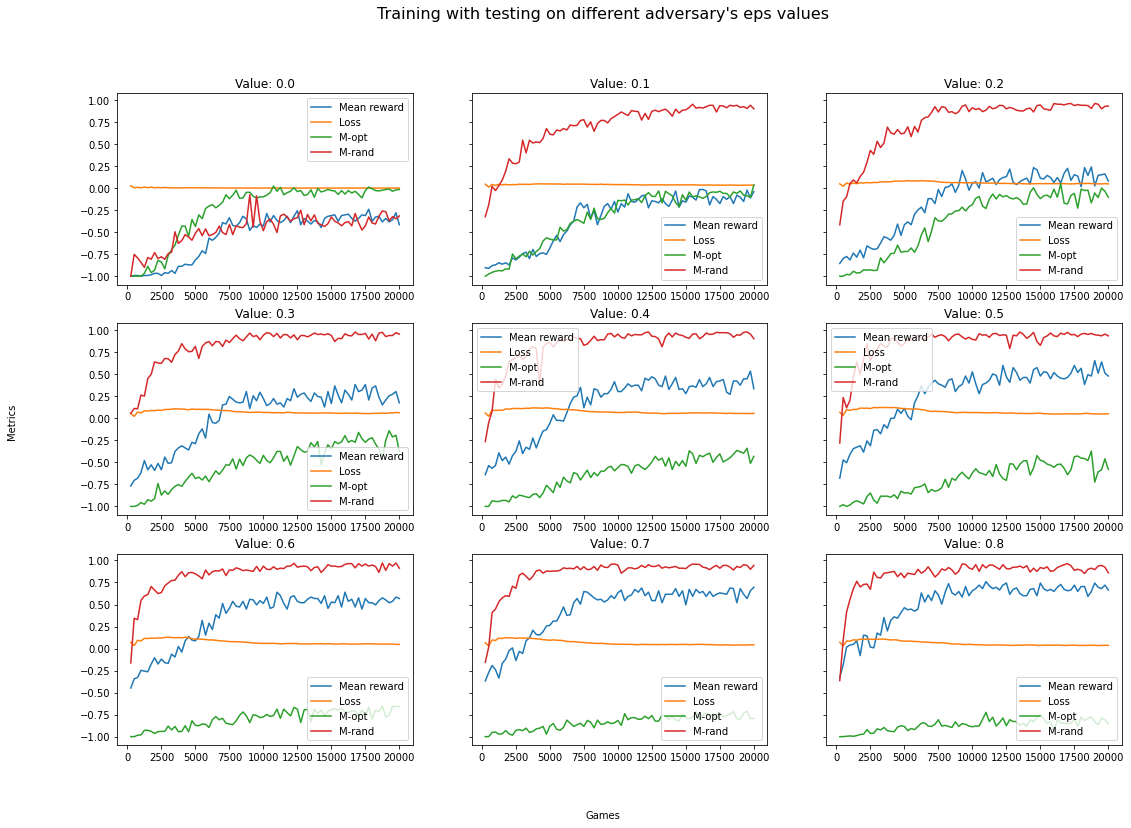

In [30]:
eps_adv_values = np.linspace(0,1,11)
question14_results = deep_q_questions_results[3]
single_image_subplots("Training with testing on different adversary's eps values", question14_results, eps_adv_values, 3, tot_height=12, tot_width=18)

### Question 15
What are the highest values of Mopt and Mrand that you could achieve after playing 20’000 games?

## 3.3 Learning by self-practice
For different values of eps ∈ [0, 1), run a DQN agent against itself for 20’000 games – i.e. both players use the same neural network and share the same replay buffer.
### Question 16
After every 250 games during training, compute the ‘test’ Mopt and Mrand for different values of eps ∈ [0, 1). Plot Mopt and Mrand over time. Does the agent learn to play Nim? What is the effect of eps?
Expected answer: A figure showing Mopt and Mrand over time for different values of eps ∈ [0, 1) (caption length < 100 words)

In [31]:
if not use_backup:
    question16_results=[]
    eps_values = np.linspace(0,1,11)
    for eps in eps_values:
        metrics, _  =  deep_q_learning(player_dqn=DQNAgent( epsilon= eps), maxGames=20000, test=True, self_learning= True)
        question16_results.append(metrics)
    deep_q_questions_results.append(question16_results)

100%|██████████| 20000/20000 [08:39<00:00, 38.50it/s]


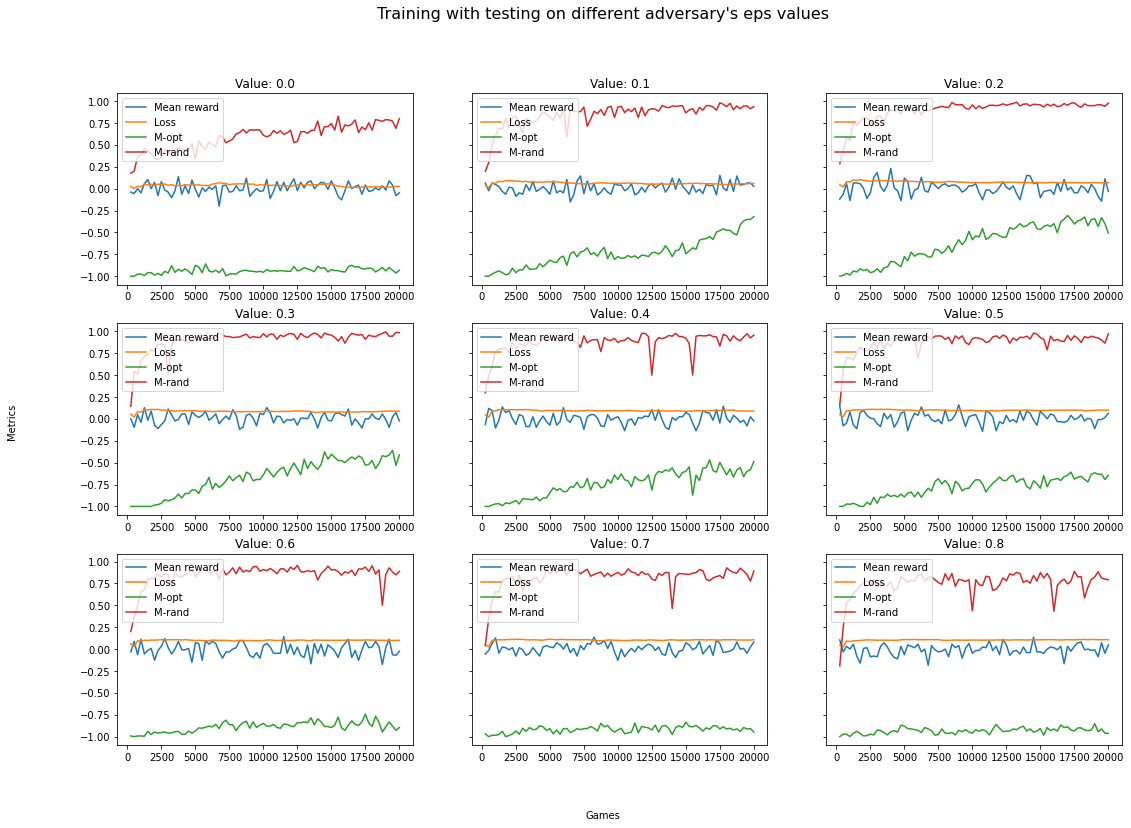

In [33]:
eps_values = np.linspace(0,1,11)
question16_results = deep_q_questions_results[4]
single_image_subplots("Training with testing on different adversary's eps values", question16_results, eps_values, 3, tot_height=12, tot_width=18)

Instead of fixing eps, use eps(n) in Equation 1 with different values of n*.
### Question 17
After every 250 games during training, compute the ‘test’ Mopt and Mrand for your agents. Plot Mopt and Mrand over time. Does decreasing eps help training compared to having a fixed eps? What is the effect of n*?
Expected answer: A figure showing Mopt and Mrand over time for different values of speeds of n* (caption length < 100 words).

In [34]:
if not use_backup:
    question17_results=[]
    n_star_values=np.linspace(1,40000,6)
    for n_star in n_star_values:
        metrics, _  =  deep_q_learning(player_dqn=DQNAgent(epsilon_min=0.1, epsilon_max=0.8, n_star= n_star), maxGames=20000, test=True,self_learning= True)
        question17_results.append(metrics)
    deep_q_questions_results.append(question17_results)

100%|██████████| 20000/20000 [09:12<00:00, 36.23it/s]


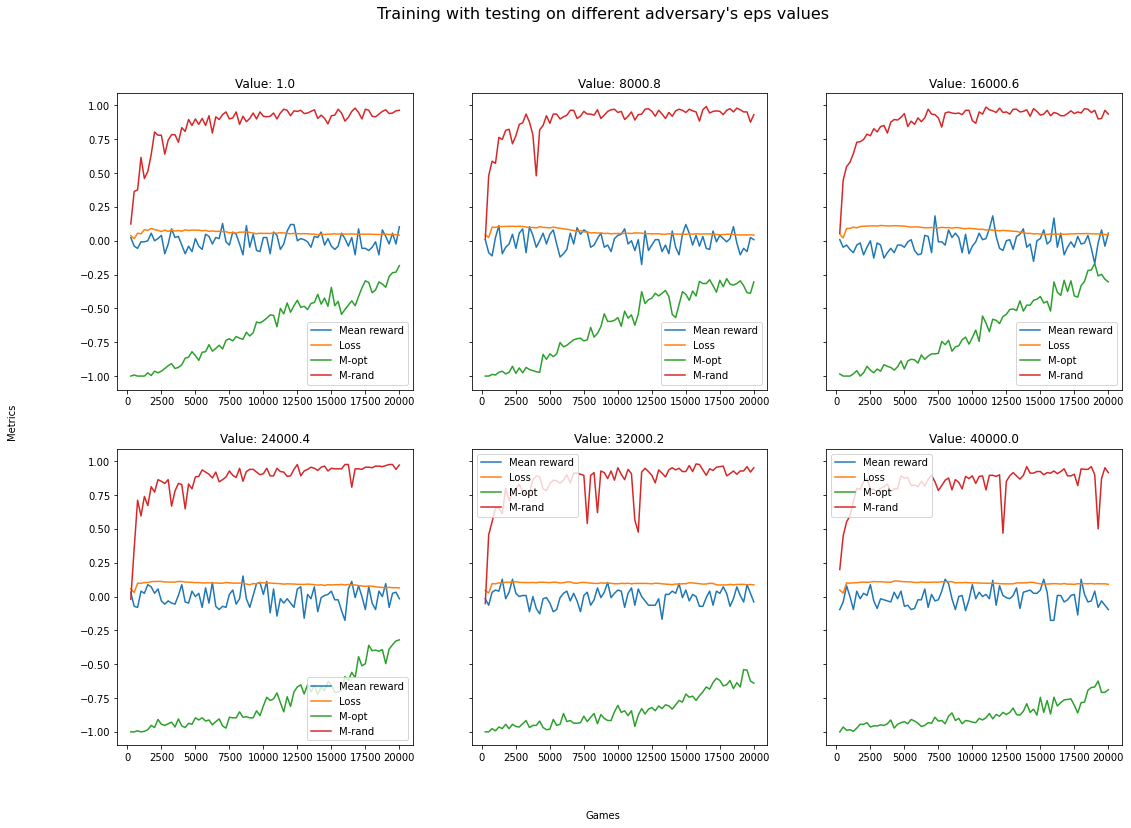

In [37]:
n_star_values=np.linspace(1,40000,6)
question17_results = deep_q_questions_results[5]
single_image_subplots("Training with testing on different adversary's eps values", question17_results, n_star_values, 3, tot_height=12, tot_width=18)

### Question 18
 What are the highest values of Mopt and Mrand that you could achieve after playing 20’000 games?

### Question 19
For three board arrangements (i.e. states s), visualize Q-values of all actions (e.g. using heat maps). Does the result make sense? Did the agent learn the game well?
Expected answer: A figure with 3 subplots each showing a state with Q-values shown at available actions (caption length < 200 words).

In [50]:
if not use_backup:
    metrics, dqn_agent  =  deep_q_learning(player_dqn=DQNAgent(epsilon_min=0.1, epsilon_max=0.8, n_star=16000 ), maxGames=40000, test=True,self_learning= True)
    deep_q_questions_results.append([metrics,dqn_agent])

100%|██████████| 40000/40000 [13:23<00:00, 49.77it/s]


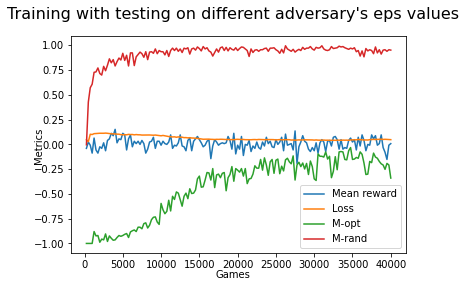

In [60]:
metrics = deep_q_questions_results[6][0]
output = []
output.append(metrics)
single_image_subplots("Training with testing on different adversary's eps values", output)

In [58]:
deep_q_agent = deep_q_questions_results[6][1]
heaps=[[4,0,0],[1,2,0],[1,0,1]]
for i in range(3):
    state = deep_q_agent.heaps_to_binary(heaps[i])
    with torch.no_grad():
        q_values = deep_q_agent.model(state)
    print(heaps[i])
    print(q_values)

[4, 0, 0]
tensor([-0.3201, -0.1153,  0.0427,  0.9872, -0.9467, -0.3508, -0.8502, -2.0463,
        -1.2087, -0.9230, -2.1367, -1.0358, -1.4136, -0.7757, -0.9284, -1.2338,
        -0.5651, -1.2060, -0.9917, -1.5171, -1.3308], device='cuda:0')
[1, 2, 0]
tensor([-0.8523, -0.9188, -0.6487, -0.8624, -0.8008, -1.0404, -1.1818,  0.9749,
        -0.1337, -0.6339, -1.5225, -0.3761, -0.8642, -1.1355, -1.0133, -0.8510,
        -2.1348, -1.0637, -1.0231, -1.0022, -1.0285], device='cuda:0')
[1, 0, 1]
tensor([-1.0246, -0.9893, -1.0169, -0.9870, -0.9605, -1.0090, -0.9879, -0.9895,
        -0.9987, -0.9955, -0.9681, -0.9603, -1.0250, -1.0428, -1.0039, -1.0110,
        -0.9760, -1.0099, -0.9984, -1.0015, -0.9757], device='cuda:0')


In [44]:
file_name = "deep_q_learning_results.pkl"
open_file = open(file_name, "wb")
pickle.dump(deep_q_questions_results, open_file)
open_file.close()

# 4 Comparing Q-Learning with Deep Q-Learning
We define the training time Ttrain as the number of games an algorithm needs to play in order to reach 80% of its final performance according to both Mopt and Mrand.
### Question 20
Include a table showing the best performance (the highest Mopt and Mrand) of Q-Learning and DQN (both for learning from experts and for learning by self-practice) and their corresponding
training time.
Expected answer: A table showing 12 values.


### Question 21
 Compare your results for DQN and Q-Learning (answer length < 300 words).